# Importing Necessary Libraries

In [1]:
import keras
import gc
from keras import backend as K
from keras.applications import ResNet50, InceptionV3, InceptionResNetV2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import model_building_evaluation as mds5
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Grid Search
Performs a grid search on different combinations of parameters to obtain the best resulting combination for each model architecture.

In [8]:
# Set the base model to one of the following: InceptionResnetV2, InceptionV3, ResNet50
base_model = "InceptionResnetV2" 

# Defining hyper parameters to be used
optimizers = ["adam", "rmsprop", "nadam"]
learning_rates = [0.001, 0.0005, 0.0001]
include = [True, False] 
batch_size = [16, 32]
epochs = 50

# Defining paths to save model and weights
weight_path = f"weights/weights.{base_model}.hdf5"
save_path=f"saved_model/{base_model}.h5"

# Creating backbone model
if base_model == "InceptionResnetV2":
    IMG_SIZE = 299
    backbone = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))
elif base_model == "InceptionV3":
    IMG_SIZE = 299
    backbone = InceptionV3(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))
else:	
    IMG_SIZE = 224
    backbone = ResNet50(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))
    
# Loading dataset images    
benign_data = np.array(mds5.Dataset_loader('Photos/Benign',IMG_SIZE))
insitu_data = np.array(mds5.Dataset_loader('Photos/InSitu',IMG_SIZE))
invasive_data = np.array(mds5.Dataset_loader('Photos/Invasive',IMG_SIZE))
normal_data = np.array(mds5.Dataset_loader('Photos/Normal',IMG_SIZE))

# Preparing the dataset for training
X, Y = mds5.create_labels([benign_data, insitu_data, invasive_data, normal_data], num_class = 4)
x_train, x_val, x_test, y_train, y_val, y_test = mds5.train_valid_test_split(X, Y, 0.7)

# Grid search to find best combination of hyperparameters
best_acc = -np.inf
for bs in batch_size:
    for lr in learning_rates:
        for inc in include:
            for opt in optimizers:
                K.clear_session()
                gc.collect()
                
                model = mds5.build_model(backbone, lr = lr, opt = opt, include = inc)

                history = mds5.train_model(model, x_train, y_train, x_val, y_val, bs, epochs, filepath = weight_path, verbose = 0)

                model.load_weights(weight_path) # load the best checkpoint weights
                
                accuracy, precision, recall, f1 = mds5.evaluate_model(model, x_test, y_test)

                print(f"batch size: {bs}, learning rate: {lr}, include: {inc}, optimizer: {opt}")
                print(f"\taccuracy: {accuracy}, precision: {precision}, recall: {recall}, f1-score: {f1}")
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_history = history
                    best_bs = bs
                    best_lr = lr
                    best_inc = inc
                    best_opt = opt
                    keras.models.save_model(model, save_path)

print(f"Best {base_model} model is with batch size: {best_bs}, learning rate: {best_lr}, include: {best_inc}, optimizer: {best_opt}")
print(f"\taccuracy: {best_acc}")         

100%|██████████| 101/101 [00:01<00:00, 79.06it/s]


2/2 [==============================] - 2s 231ms/step
batch size: 16, learning rate: 0.001, include: True, optimizer: adam
	accuracy: 0.7333333333333333, precision: 0.775, recall: 0.7301448551448552, f1-score: 0.735568140299598
2/2 [==============================] - 3s 239ms/step
batch size: 16, learning rate: 0.001, include: True, optimizer: rmsprop
	accuracy: 0.7666666666666667, precision: 0.7644162210338681, recall: 0.7707292707292708, f1-score: 0.7638582782341548
2/2 [==============================] - 3s 237ms/step
batch size: 16, learning rate: 0.001, include: True, optimizer: nadam
	accuracy: 0.75, precision: 0.8118700265251989, recall: 0.7350149850149851, f1-score: 0.757703081232493
2/2 [==============================] - 2s 235ms/step
batch size: 16, learning rate: 0.001, include: False, optimizer: adam
	accuracy: 0.8166666666666667, precision: 0.8244969040247678, recall: 0.8349150849150849, f1-score: 0.8260616426641124
2/2 [==============================] - 3s 236ms/step
batch s

# Loading best trained model

In [11]:
best_model = keras.models.load_model(save_path)

# Plot training progress
This is to observe the training and validation accuracies and losses across the trained epochs to monitor if overfitting has occurred

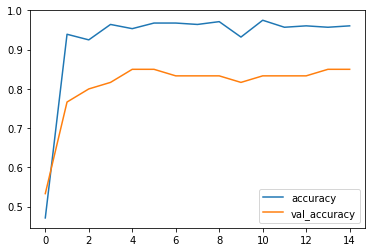

In [21]:
mds5.plot_training_accuracies(best_history)

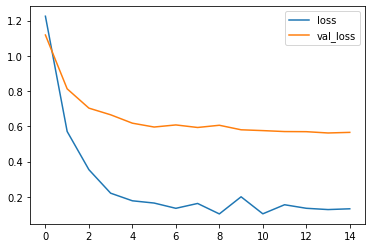

In [22]:
mds5.plot_training_losses(best_history)

# K-Fold Cross Validation
This is to test the robustness of the model and its ability to generalize to unseen data

In [12]:
mds5.kfold(5, x_train, y_train, best_model)

2/2 [==============================] - 3s 228ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.94      0.97        18
           2       0.94      1.00      0.97        15
           3       1.00      1.00      1.00        11

    accuracy                           0.98        56
   macro avg       0.98      0.99      0.98        56
weighted avg       0.98      0.98      0.98        56

2/2 [==============================] - 0s 227ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        19

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

2/2 [===================

0.9964285714285716

# Evaluation of standard performance metrics
Evaluation of standard performance metrics to compare with literature read

In [13]:
accuracy, precision, recall, f1 = mds5.evaluate_model(best_model, x_test, y_test)
print(f"accuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1-score: {f1}")

2/2 [==============================] - 0s 230ms/step
accuracy: 0.8833333333333333
precision: 0.8854166666666666
recall: 0.8773726273726273
f1-score: 0.8789297658862876


# Confusion Matrix
To observe if model has a balance performance for all output classes

2/2 [==============================] - 0s 234ms/step


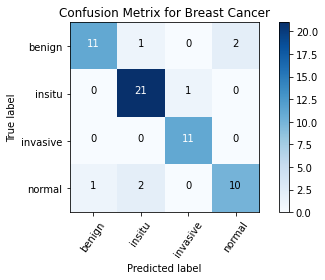

In [14]:
y_pred = best_model.predict(x_test)
cm = mds5.plot_confusion_matrix(y_test, y_pred, ['benign', 'insitu', 'invasive', 'normal'] , title ='Confusion Metrix for Breast Cancer')